## Part 1 - Corner detection
#### *Pol Roca Llaberia*


### Harris vs Shi-Tomasi vs FAST corners

**Harris** and **Shi-Tomasi** methods are two variants of the same approach: they compute the autocorrelation matrix using the derivatives, they extract the eigenvalues (or an approximation) and then they apply some criteria to tell apart possible corner points. The only thing that distinguishes these two methods is the way they interpret the eigenvalues, and with that, Shi-Tomasi is said to be an improvement over Harris corners. 

On the counterpart, **FAST** bases its detection on the pixels that fall in a circular neighbourhood by comparing them to the center pixel. Theoretically, it may not be as accurate as the previous methods, however, the main focus of this algorithm is to improve performance and reduce response time.

In this notebook we will perform a small comparison of these detectors using general purpose images, but before that, we must first determine some parameters. We will do it empirically.

In [1]:
from matplotlib import pyplot as plt

from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks, corner_fast, corner_shi_tomasi
from skimage.transform import warp, AffineTransform
from skimage.color import rgb2gray
from skimage.draw import ellipse

In [2]:
# Sheared checkerboard
tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,
                        translation=(110, 30))
image = warp(data.checkerboard()[:90, :90], tform.inverse,
             output_shape=(200, 310))
             
# Ellipse
rr, cc = ellipse(160, 175, 10, 100)
image[rr, cc] = 1

# Two squares
image[30:80, 200:250] = 1
image[80:130, 250:300] = 1

def plot_image_corners(ax, image, coords):
    coords_subpix = corner_subpix(image, coords, window_size=13)

    ax.imshow(image, cmap=plt.cm.gray)
    ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
            linestyle='None', markersize=6)
    ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)

    ax.set_axis_off()

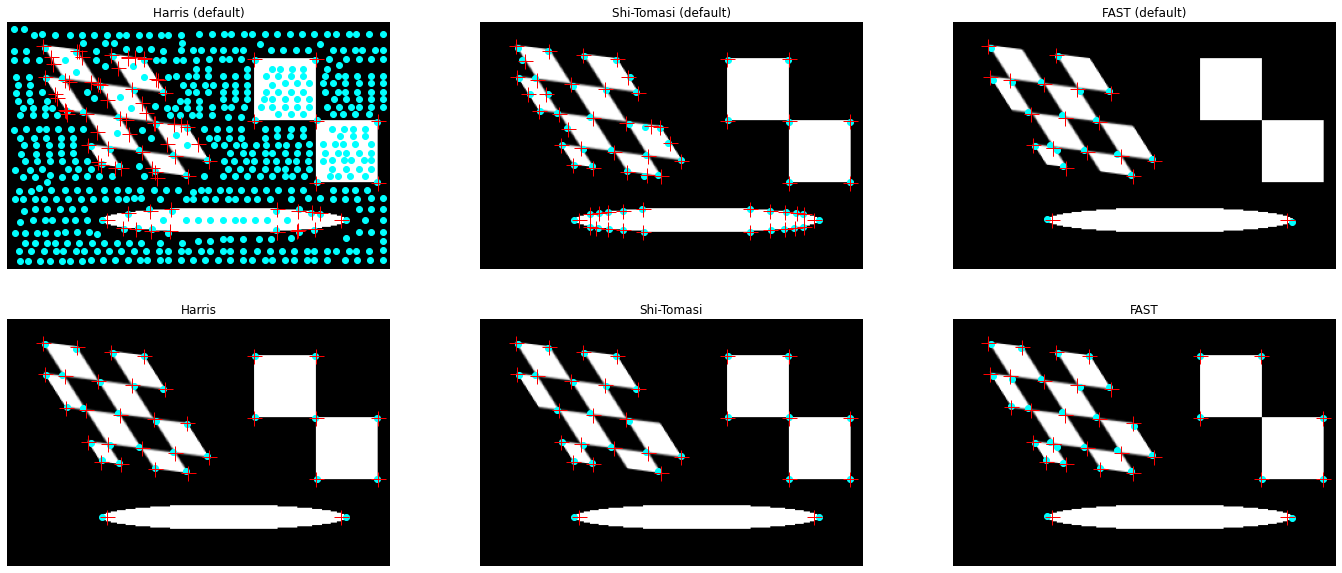

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(24, 10))

# Harris (default)
ax[0, 0].set_title('Harris (default)')
coords = corner_peaks(corner_harris(image), min_distance=5)
plot_image_corners(ax[0, 0], image, coords)

# Shi-Tomasi (default)
ax[0, 1].set_title('Shi-Tomasi (default)')
coords = corner_peaks(corner_shi_tomasi(image), min_distance=5)
plot_image_corners(ax[0, 1], image, coords)

# FAST (default)
ax[0, 2].set_title('FAST (default)')
coords = corner_peaks(corner_fast(image), min_distance=5)
plot_image_corners(ax[0, 2], image, coords)


# Harris
ax[1, 0].set_title('Harris')
coords = corner_peaks(corner_harris(image), min_distance=5, threshold_rel=0.02)
plot_image_corners(ax[1, 0], image, coords)

# Shi-Tomasi
ax[1, 1].set_title('Shi-Tomasi')
coords = corner_peaks(corner_shi_tomasi(image), min_distance=5, threshold_rel=0.101)
plot_image_corners(ax[1, 1], image, coords)

# FAST
ax[1, 2].set_title('FAST')
coords = corner_peaks(corner_fast(image, n=9), min_distance=5, threshold_rel=0.4)
plot_image_corners(ax[1, 2], image, coords)

plt.show()

As we see in the previous cell, setting the correct parameters for the algorithms is important as the result changes significantly when they are adjusted.
The criterion we follow to at least try to carry out a fair comparison is the next one. Using the synthetic image from above and considering that a good result is the one produced by the Harris detector (bottom left), we look for the highest relative threshold that can be set in order to produce a result as close as possible to that best result. Additionaly and more specifically, for FAST the parameter *n* (which is the min number of contiguous pixels) is set to 9, which is the minimum amount to detect corners and still avoid edges.

From now on we will use these same parameters because we assume that in practice when analyzing many images we would not be able to tune each parameter for each single image.

In [4]:
thresh_harris = 0.02
thresh_shitomasi = 0.101
thresh_fast = 0.4

def plot_comparison(img):
    fig, ax = plt.subplots(1, 3, figsize=(22, 8))

    # Harris
    ax[0].set_title('Harris')
    coords = corner_peaks(corner_harris(img), min_distance=5, threshold_rel=thresh_harris)
    plot_image_corners(ax[0], img, coords)

    # Shi-Tomasi
    ax[1].set_title('Shi-Tomasi')
    coords = corner_peaks(corner_shi_tomasi(img), min_distance=5, threshold_rel=thresh_shitomasi)
    plot_image_corners(ax[1], img, coords)

    # FAST
    ax[2].set_title('FAST')
    coords = corner_peaks(corner_fast(img, n=9), min_distance=5, threshold_rel=thresh_fast)
    plot_image_corners(ax[2], img, coords)

    plt.subplots_adjust(wspace=0.07)
    plt.show()

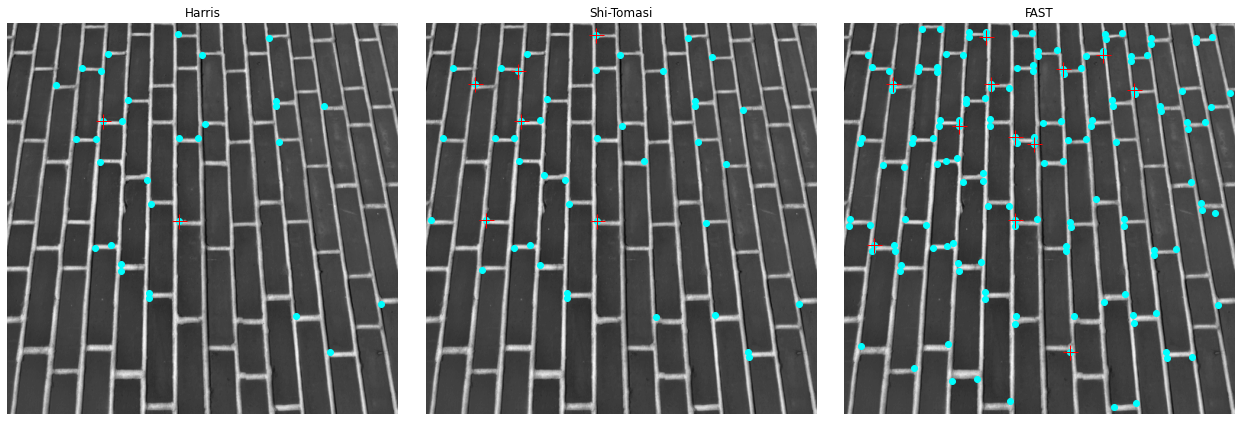

In [5]:
img = rgb2gray(data.brick())
plot_comparison(img)

The first image to test are the bricks. In this image we should be able to detect the corners of each brick since the color in-between is fairly lighter than that of the bricks. Apparently, Harris and Shi-Tomasi algorithms have been able to find some corners but in general they have missed many. As for FAST, this one has been able to find most of the corners.

Here, the reason why the two first methods do not obtain good results could be due to the relative threshold being set too high. However, this parameter acts as a tradeoff: if we set it too low, then they will recognize more corners in this case but on the next images we will also see way too many incorrect points.

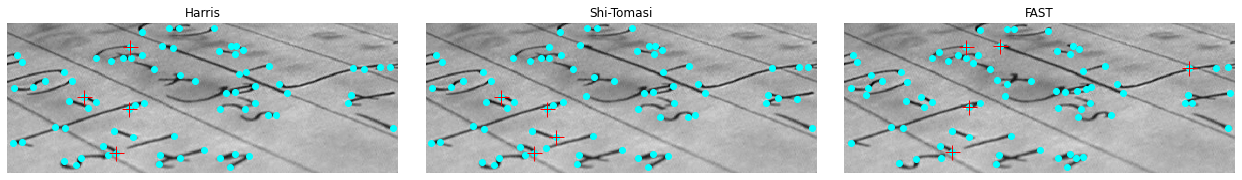

In [6]:
img = rgb2gray(data.text())
plot_comparison(img)

In this case we could say all three algorithms have successfully found almost all the interest points in the image. Probably, this high accuracy is a result of the background being much lighter than the text (although it also has some soft stains / noise), and because the letters are quite sharp, so that there is much contrast change in short distance.

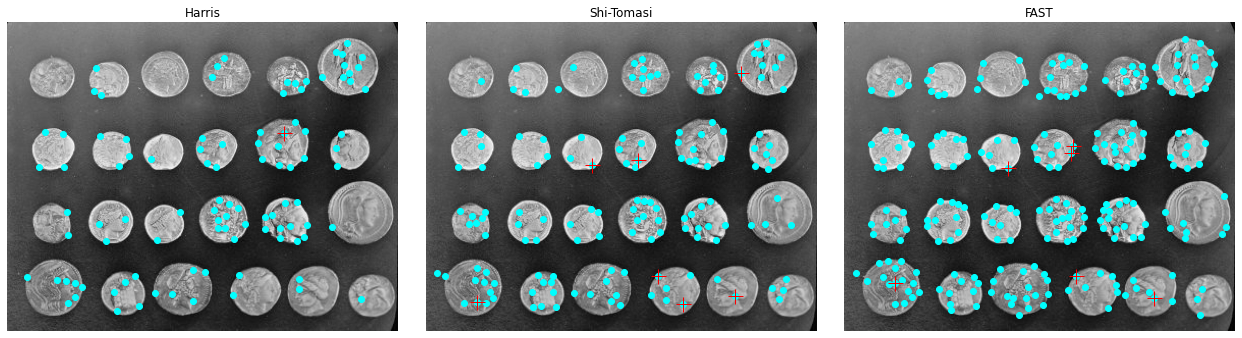

In [7]:
img = rgb2gray(data.coins())
plot_comparison(img)

This image was examined because on a first glance, one could think no corners should be found in it since coins are round. Despite, the three algorithms have been able to recognize interest points from the *heads* of these coins even though their texture is not so contrasted. Unfortunately, they have also found some points on the edges of coins and we can realize that most of these are not unique enough, as they can be found in different pieces, and a feature descriptor based on gradients would most certainly mismatch them.

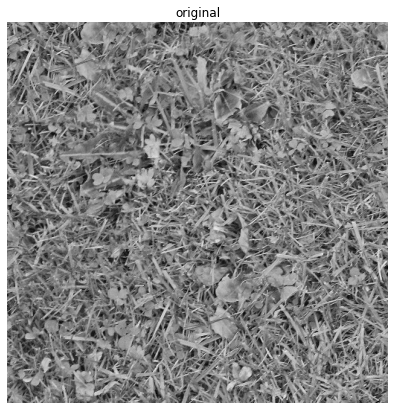

<Figure size 432x288 with 0 Axes>

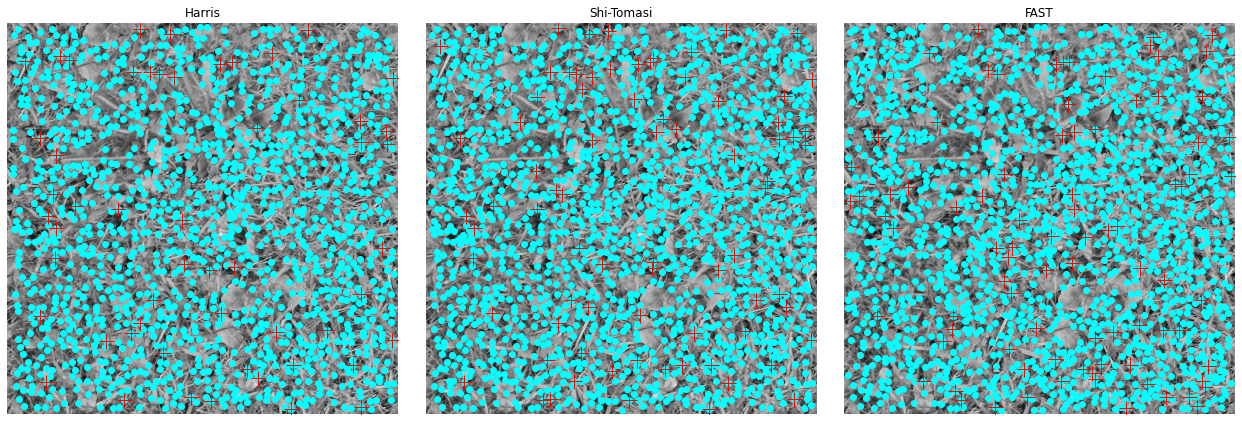

In [8]:
plt.figure(figsize=(7, 7))
plt.imshow(data.grass(), cmap='gray')
plt.title('original')
plt.axis('off')

plt.figure()
img = rgb2gray(data.grass())
plot_comparison(img)

This image of grass with an heterogeneous texture allows us to test an extreme case where there are lots of contrast changes in all directions and magnitudes. It was merely included so as to see if there is any strange behaviour with any of the algorithms. Seemingly, all methods have been able to find a vast amount of keypoints as expected, providing a very similar result.

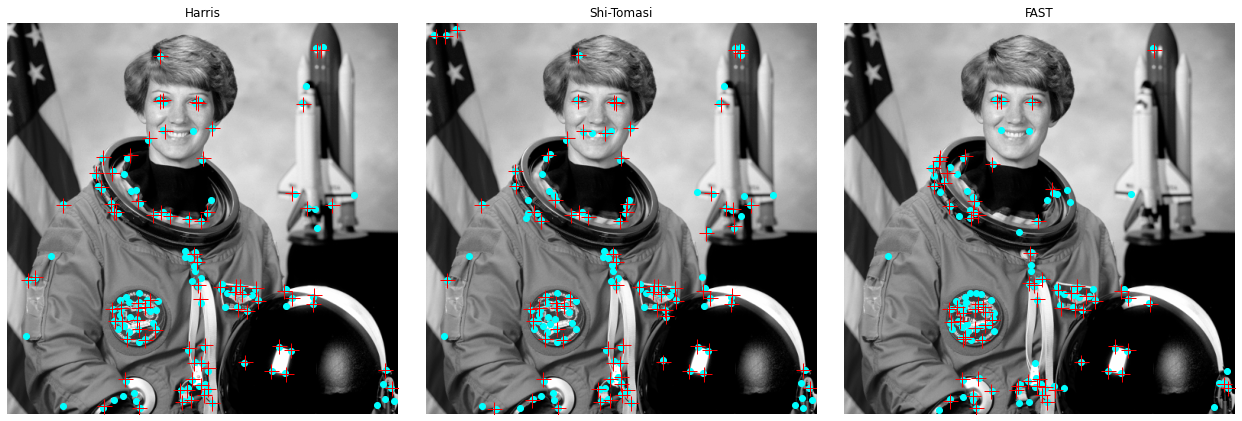

In [9]:
img = rgb2gray(data.astronaut())
plot_comparison(img)

Here, we have a typical scene of a woman with some objects on the background. For being a common case, all three algorithms should be able to find solid keypoints otherwise their usability would be compromised. As we see, all of them have successfully found the most remarkable points such as the eyes of the woman, the smile, the logos on her jacket and the high contrasted specular light on the helmet. 

Harris and Shi-Tomasi methods show a similar set of points which is normal since their logic is very similar, with the second one being a bit more sensible as we can see from the additional points on her mouth.

Apart from that, we must also note that FAST has not been able to recognize almost any point from the toy spaceship at the brackground, which is significant since the other methods have found many, specially Shi-Tomasi. Partly, this could be because the background is slightly out of focus, causing the corners or keypoints to be less sharp and the contrast change more gradual, although this affects the three methods equally.

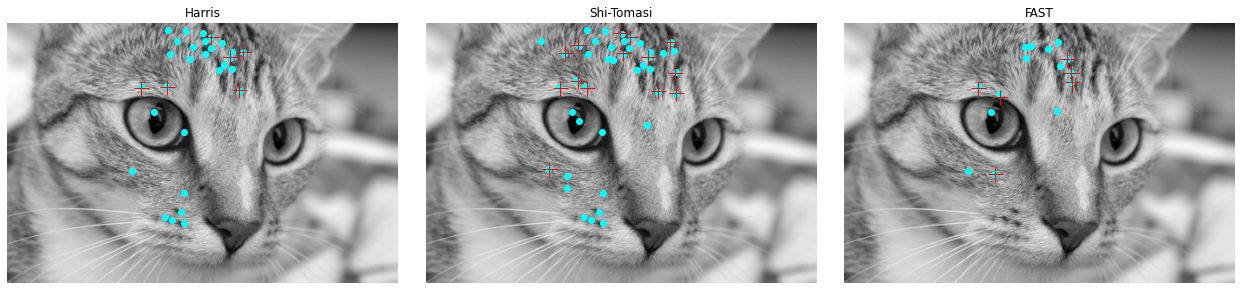

In [10]:
img = rgb2gray(data.cat())
plot_comparison(img)

This image of a cat is different from the other scenes for being a very detailed close portrait and with the natural heterogeneous texture of its fur. Shi-Tomasi is able to find many points, followed by Harris and lastly FAST, which is the one that found the least amount. 

This is a difficult image to analyze because of the texture. Specially for use cases where more than one image of a scene is used, all these keypoints found on the cat's fur might probably be useless because they are very unreliable since it is a 3D texture that changes notably with small changes in the point of view. In that sense, Shi-Tomasi has done a great job finding additional points on its eyes as these are more reliable.

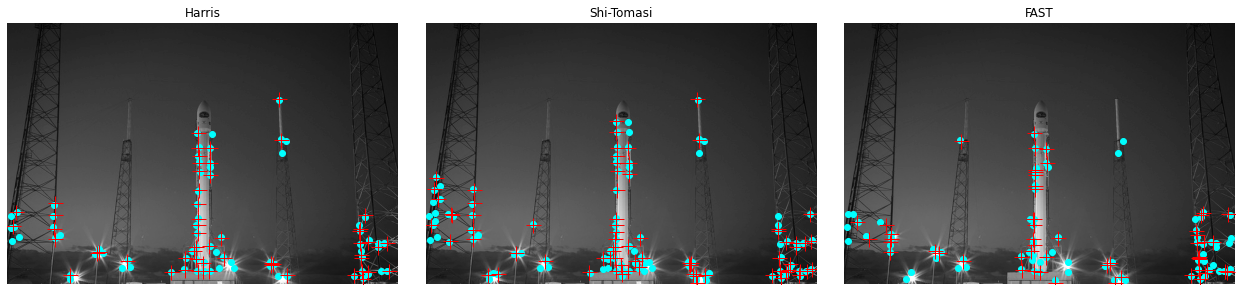

In [11]:
img = rgb2gray(data.rocket())
plot_comparison(img)

In this last case we have a scene of the takeoff of a spaceship in the night. The main problem with this image is the low amount of light. 

The first two methods have shown similar results with Shi-Tomasi finding some more points, again. None of the algorithms have been able to recognize the tip of the left antenna as a corner, probably because of the unnoticeable contrast change with the sky. To the right, however, FAST has been the only one unable to find a corner on the tip of this antenna, which should be a robust point. It seems that for this image the algorithms' threshold parameters should have been tuned by hand because as of right now, many parts of the structure of the antennas have not been recognized as keypoints despite some of them that are more visible have been. 

In general, though, most of the corners/keypoints found in this image are not robust enough since they are not unique. In particular, the ones found in the pattern of the structure of the antennas, the ones found on the sides of the rocket and the ones found on the star-shaped lights, which can be identified in many places.

In [25]:
img = rgb2gray(data.rocket())

print('Harris: ', end='')
%timeit corner_harris(img)
print('Shi-Tomasi: ', end='')
%timeit corner_shi_tomasi(img)
print('FAST: ', end='')
%timeit corner_fast(img, n=9)

Harris:	20.6 ms ± 565 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Shi-Tomasi:	20.7 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
FAST:	15 ms ± 212 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Final word

In conclusion, we could say that with this configuration of parameters all three algorithms seem to perform well. Among their differences, the most noticeable ones are that Shi-Tomasi, despite being very similar to it, normally recognizes more corners than Harris. On the contrary, FAST generally finds less keypoints (with some exceptions). Nonetheless, we must take into account the fact that FAST is normally *faster* than the others, as it was demonstrated in its paper. In the last cell, for example, we can already see a 25% increase in speed from FAST.

In the end, if we were to pick one of the three options I think the decision would depend on the requirements. If performance in terms of speed was required, I would employ FAST because it is faster and even though in some situations it proposes less keypoints, it is also true that in the majority of cases the most meaningful points can still be found (or even more, sometimes). On the other hand, if speed was not an issue, I would most surely employ the Shi-Tomasi detector for being more sensible and being able to propose more points, which sometimes, could be more important.